In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt


# ------------------------- Config -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
batch_size = 128
epochs = 10
feat_dim = 256           # projection output dim (embedding space for center loss)
center_weight = 0.01     # <-- tune this (0.001–0.1). Smaller = less pull to centers
focal_weight = 1.0

In [2]:
# ------------------------- Losses (your definitions) -------------------------
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        """
        features: (N, feat_dim)
        labels:   (N,) long
        """
        batch_size = features.size(0)
        centers_batch = self.centers.index_select(0, labels.long())
        center_loss = torch.sum((features - centers_batch) ** 2) / (2.0 * batch_size)
        return center_loss


class MultiClassFocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        # inputs: (N, C) logits if self.logits=True; else probs
        # targets: (N,) long
        if self.logits:
            bce = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        else:
            # inputs are probs; NLL of the correct class
            bce = -torch.log(inputs[range(targets.shape[0]), targets].clamp(min=1e-12))

        pt = torch.exp(-bce)
        f_loss = self.alpha * (1 - pt) ** self.gamma * bce
        return f_loss.mean() if self.reduce else f_loss


class FocalCenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device, alpha=1, gamma=2, logits=True, reduce=True,
                 center_weight=1.0, focal_weight=1.0):
        super(FocalCenterLoss, self).__init__()
        self.center_loss = CenterLoss(num_classes, feat_dim, device)
        self.focal_loss = MultiClassFocalLoss(alpha, gamma, logits, reduce)
        self.center_weight = center_weight
        self.focal_weight = focal_weight

    def forward(self, features, labels, outputs):
        # features: (N, feat_dim)  | labels: (N,) long | outputs: (N, C) logits
        loss_center = self.center_loss(features, labels)
        loss_focal  = self.focal_loss(outputs, labels)
        return self.center_weight * loss_center + self.focal_weight * loss_focal

In [3]:
# ------------------------- Data -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
num_classes = len(train_dataset.classes)
print("class_to_idx:", train_dataset.class_to_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

# ------------------------- Model (torchvision ViT-B/16) -------------------------
vit = models.vit_b_16(pretrained=True).to(device)
# Freeze the backbone
for p in vit.parameters():
    p.requires_grad = False
vit.eval()

# helper: extract CLS embedding (torchvision ViT)
@torch.no_grad()
def vit_cls_features(tv_vit, x):
    # x: (N,3,224,224), ImageNet-normalized
    x = tv_vit._process_input(x)
    n = x.shape[0]
    cls_tok = tv_vit.class_token.expand(n, -1, -1)  # (N,1,D)
    x = torch.cat((cls_tok, x), dim=1)              # (N,1+L,D)
    x = tv_vit.encoder(x)                           # transformer blocks
    return x[:, 0]                                  # CLS embedding (N,D)

in_features = vit.heads.head.in_features  # 768 for ViT-B/16

# Small trainable projection + classifier (we don't use vit's built-in head)
proj = nn.Linear(in_features, feat_dim).to(device)
cls_head = nn.Linear(feat_dim, num_classes).to(device)

# Only optimize projection + classifier + centers (inside the loss)
criterion = FocalCenterLoss(
    num_classes=num_classes,
    feat_dim=feat_dim,
    device=device,
    alpha=1.0,
    gamma=2.0,
    logits=True,
    reduce=True,
    center_weight=center_weight,
    focal_weight=focal_weight,
).to(device)

optimizer = optim.Adam([
    {"params": proj.parameters(), "lr": 1e-3},
    {"params": cls_head.parameters(), "lr": 1e-3},
    # centers updated with a smaller LR usually helps stability
    {"params": criterion.center_loss.parameters(), "lr": 5e-4},
])

class_to_idx: {'Negative': 0, 'Positive': 1}


/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:

# ------------------------- Train / Eval -------------------------
def train_one_epoch():
    proj.train(); cls_head.train()
    running = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():
                feats_vit = vit_cls_features(vit, imgs)    # (N, 768)
            feats = proj(feats_vit)                        # (N, feat_dim)
            logits = cls_head(feats)                       # (N, C)
            loss = criterion(feats, y, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    proj.eval(); cls_head.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = proj(vit_cls_features(vit, imgs))
        logits = cls_head(feats)
        loss = criterion(feats, y, logits)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total

# ------------------------- Run -------------------------
best_acc = 0.0
for epoch in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()
    if acc > best_acc:
        best_acc = acc
    print(f"Epoch {epoch+1}/{epochs} | train_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | acc {acc:.3f}")
print(f"Best Acc: {best_acc:.3f}")

Epoch 1/10 | train_loss 0.9348 | val_loss 0.6110 | acc 0.862


Epoch 2/10 | train_loss 0.5255 | val_loss 0.4806 | acc 0.839


Epoch 3/10 | train_loss 0.4386 | val_loss 0.4349 | acc 0.862


Epoch 4/10 | train_loss 0.3941 | val_loss 0.4114 | acc 0.839


Epoch 5/10 | train_loss 0.3699 | val_loss 0.3948 | acc 0.862


Epoch 6/10 | train_loss 0.3495 | val_loss 0.3696 | acc 0.871


Epoch 7/10 | train_loss 0.3294 | val_loss 0.3621 | acc 0.871


Epoch 8/10 | train_loss 0.3186 | val_loss 0.3504 | acc 0.871


Epoch 9/10 | train_loss 0.3074 | val_loss 0.3383 | acc 0.885


Epoch 10/10 | train_loss 0.3122 | val_loss 0.3651 | acc 0.806
Best Acc: 0.885


In [7]:
epochs = 1

In [8]:
# ------------------------- Run -------------------------
for epoch in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()
    if acc > best_acc:
        best_acc = acc
    print(f"Epoch {epoch+1}/{epochs} | train_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | acc {acc:.3f}")
print(f"Best Acc: {best_acc:.3f}")

Epoch 1/1 | train_loss 0.2930 | val_loss 0.3199 | acc 0.885
Best Acc: 0.885


              precision    recall  f1-score   support

    Negative     0.9400    0.8981    0.9186       157
    Positive     0.7612    0.8500    0.8031        60

    accuracy                         0.8848       217
   macro avg     0.8506    0.8740    0.8609       217
weighted avg     0.8906    0.8848    0.8867       217

Confusion Matrix:
 [[141  16]
 [  9  51]]


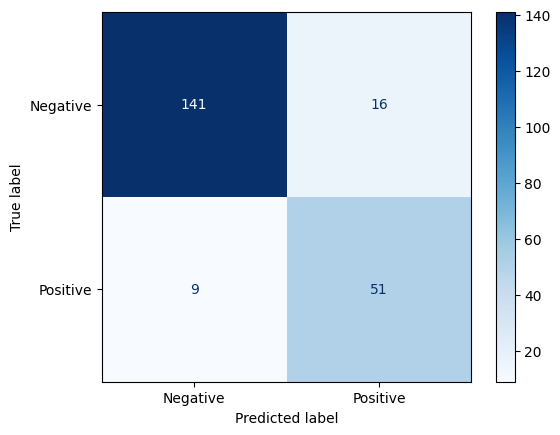

In [9]:

# ------------------------- Reports -------------------------
@torch.no_grad()
def collect_preds():
    proj.eval(); cls_head.eval()
    y_true, y_pred = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = proj(vit_cls_features(vit, imgs))
        logits = cls_head(feats)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()
